## Do Idiosyncratic Risk and Systemic Risk Affect Probabilities of Default Differently?

### Steps:
- First, we want to create a CAPM model: $ R_{firm} = \alpha + \beta R_{market} + \varepsilon $
- The $\beta$ is Systemic Risk, and we will use ${std} (\varepsilon)$ as our Idiosyncratic Risk
- Then, after computing the risks for all of our companies, we compute a linear regression of these onto the default probabilities: $PD_i = \alpha + \beta_1 Systemic_i + \beta_2 Idiosyncratic_i + \epsilon_i $




In [2]:
import pandas as pd 
import numpy as np 
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.239
Method:                 Least Squares   F-statistic:                     15.46
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           1.69e-06
Time:                        10:11:55   Log-Likelihood:                 189.60
No. Observations:                  93   AIC:                            -373.2
Df Residuals:                      90   BIC:                            -365.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

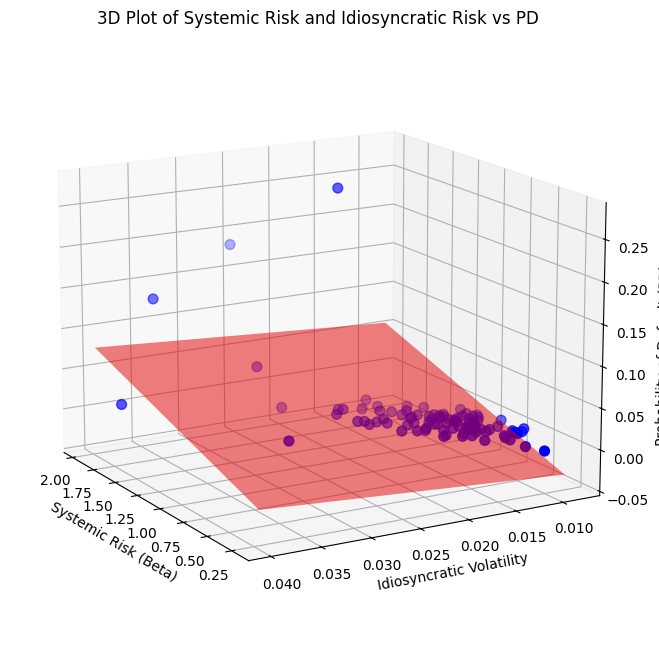

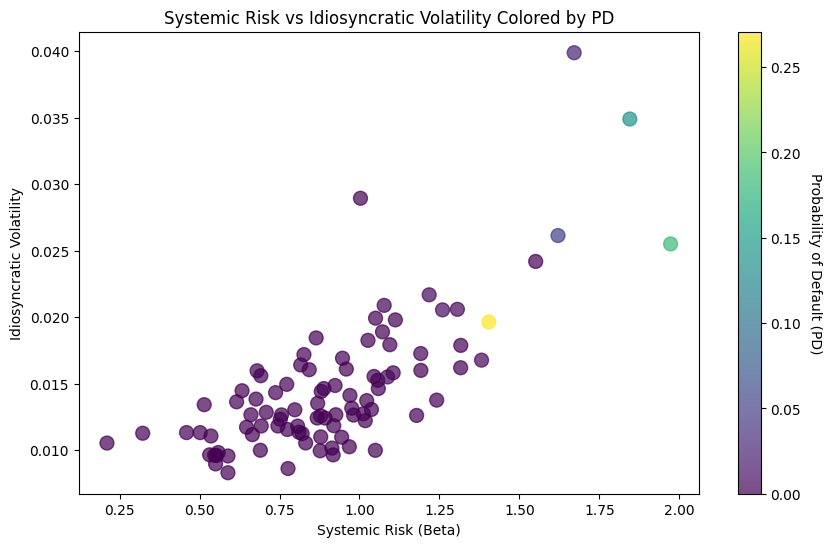

In [7]:
data = pd.read_csv(r'../data/clean_data.csv')
merton = pd.read_csv(r'../model/merton_model_output.csv')

spy_csv = pd.read_csv(r'../hypothesis-2/SPY.csv')
spy_csv['log_return'] = np.log(spy_csv['PRC'] / spy_csv['PRC'].shift(1))
spy_csv = spy_csv.set_index('date')
spy_csv.index = pd.to_datetime(spy_csv.index)

spy_logreturns = spy_csv['log_return'].dropna()


plot = False

beta_set = []
iv_set = []
pd_set = []

tics = data['tic'].unique()
tics = np.delete(tics, 18) ## BRK.B messes everything up



for i in tics:

    stock = data[data['tic'] == str(i)]
    stock = stock.set_index('date')
    stock.index = pd.to_datetime(stock.index)

    probdef = merton[merton['tic'] == str(i)]
    probdef = probdef.set_index('date')
    probdef.index = pd.to_datetime(probdef.index)
    #print(probdef.index.duplicated().sum())


    stock_logreturns = stock['log_return']


    spy_logreturns, stock_logreturns = spy_logreturns.align(stock_logreturns, join = 'inner', axis = 0)
    
         
    X = sm.add_constant(spy_logreturns)
    y = stock_logreturns
            
    model = sm.OLS(y, X)
    results = model.fit()
         
    _, beta = results.params
    residuals = results.resid
    idio_vol = np.std(residuals)
        
    beta_set.append(beta)
    iv_set.append(idio_vol)


    
    probdefff = probdef['merton_pd'].reindex(stock_logreturns.index)

    pdd = probdefff.mean()
    pd_set.append(pdd)


    #########################################################################################

rolling_results = pd.DataFrame({
        'Beta': beta_set,
        'Idiosyncratic Volatility': iv_set
    })   


X2 = sm.add_constant(rolling_results)
model2 = sm.OLS(pd_set, X2)
results2 = model2.fit()

print(results2.summary())

a, b, iv = results2.params
print(f"Sys: {b},    Scaled Sys: {b*np.std(beta_set)},      Std: {np.std(beta_set)}")
print(f"Idio: {iv},    Scaled Idio: {iv*np.std(iv_set)},    Std: {np.std(iv_set)}" )


############################################################################################


fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(beta_set, iv_set, pd_set, color = 'b', s = 50)

x_range = np.linspace(min(beta_set), max(beta_set), 100)
y_range = np.linspace(min(iv_set), max(iv_set), 100)
X_grid, Y_grid = np.meshgrid(x_range, y_range)
Z_grid = a + b * X_grid + iv * Y_grid

# Plot the surface of the regression plane
ax.plot_surface(X_grid, Y_grid, Z_grid, color='r', alpha=0.5, rstride=100, cstride=100)

# Labels and title
ax.set_xlabel('Systemic Risk (Beta)')
ax.set_ylabel('Idiosyncratic Volatility')
ax.set_zlabel('Probability of Default (PD)')
ax.set_title('3D Plot of Systemic Risk and Idiosyncratic Risk vs PD')

ax.view_init(elev=15, azim=90+60)
plt.show()
######################################################################################

plt.figure(figsize=(10, 6))

scatter = plt.scatter(beta_set, iv_set, c=pd_set, cmap='viridis', s=100, alpha=0.7)

cbar = plt.colorbar(scatter)
cbar.set_label('Probability of Default (PD)', rotation=270, labelpad=15)

# Labels and title
plt.xlabel('Systemic Risk (Beta)')
plt.ylabel('Idiosyncratic Volatility')
plt.title('Systemic Risk vs Idiosyncratic Volatility Colored by PD')



plt.show()


With this, we can see that both Idiosyncratic and Systemic Risk affect Default Probabilities differently. Looking at the coefficiencts of our Linear Regression, we see that a 1-unit change in Systemic Risk leads to a 2.7% increase in default probability, whereas a 1-unit change in Idiosyncratic Risk leads to a 97.3% increase. This seems strange, but after multiplying both of these values by the standard deviation of the Risks, we see that a 1-std change in systemic risk (0.305) leads to a 0.809% increase, whereas a 1-std change in idiosyncratic risk (0.00524) leads to a 0.0051% increase. It is interesting to see that, after scaling, Syncratic Risk has a much higher effect on the probability of default. This makes sense, becuase the risk of a specific company should affect their default probability much more than overall market risk. Another thing of note, is that the probabilities of default are not very high no matter what. The highest they go is to around .17%, which could be due to survivorship bias.

## Plotting Time Series Systemic/Idiosyncratic Risk

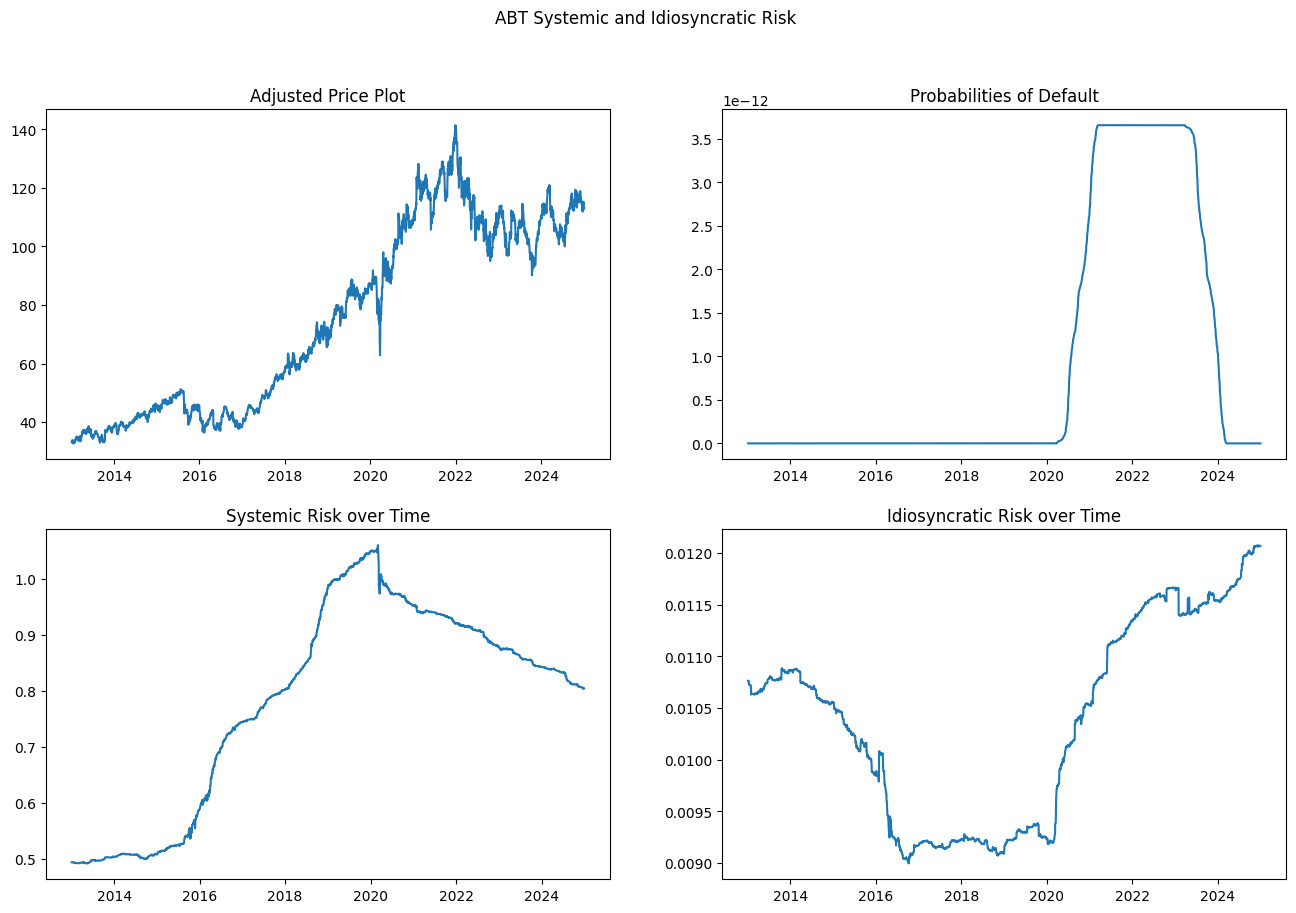

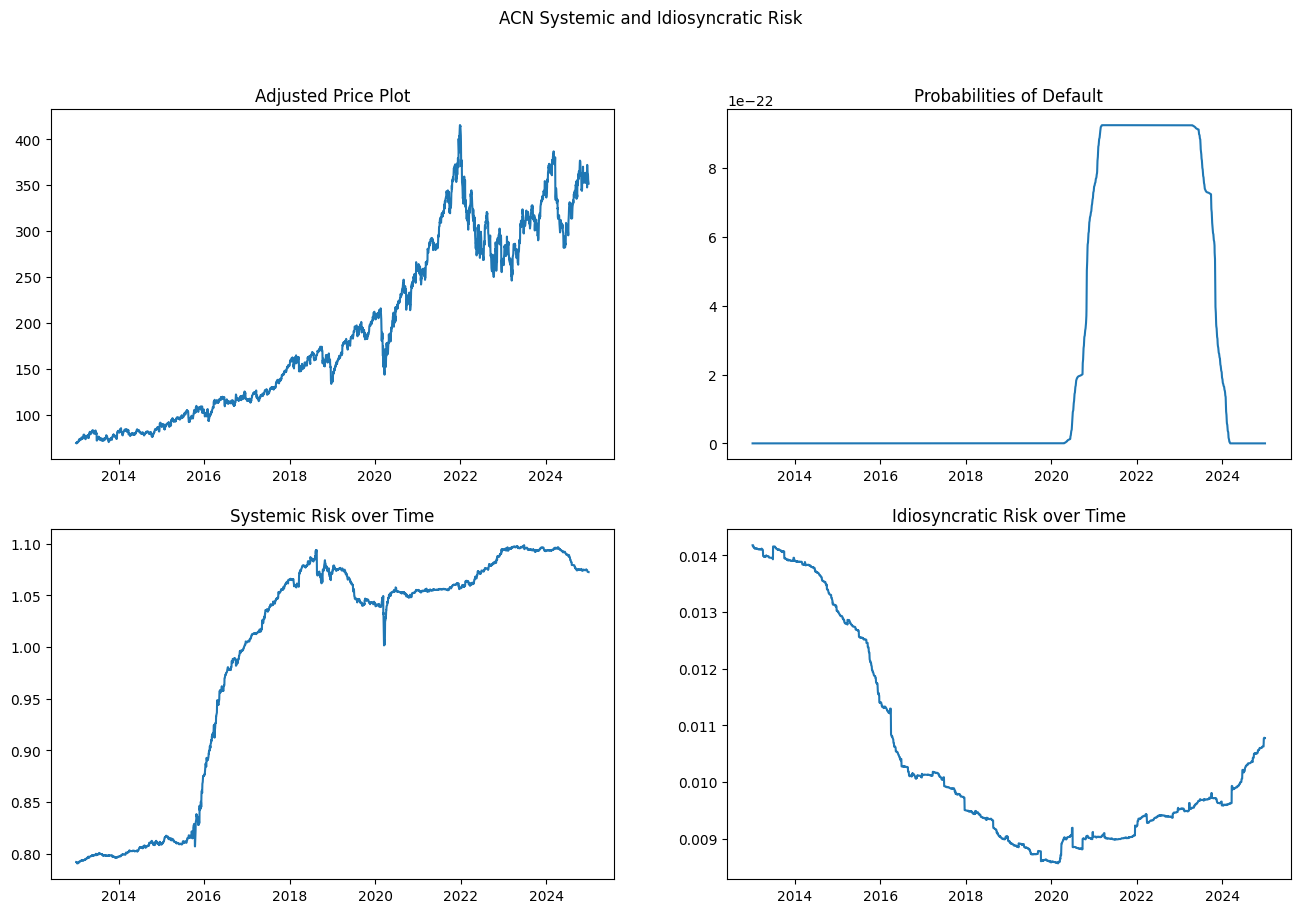

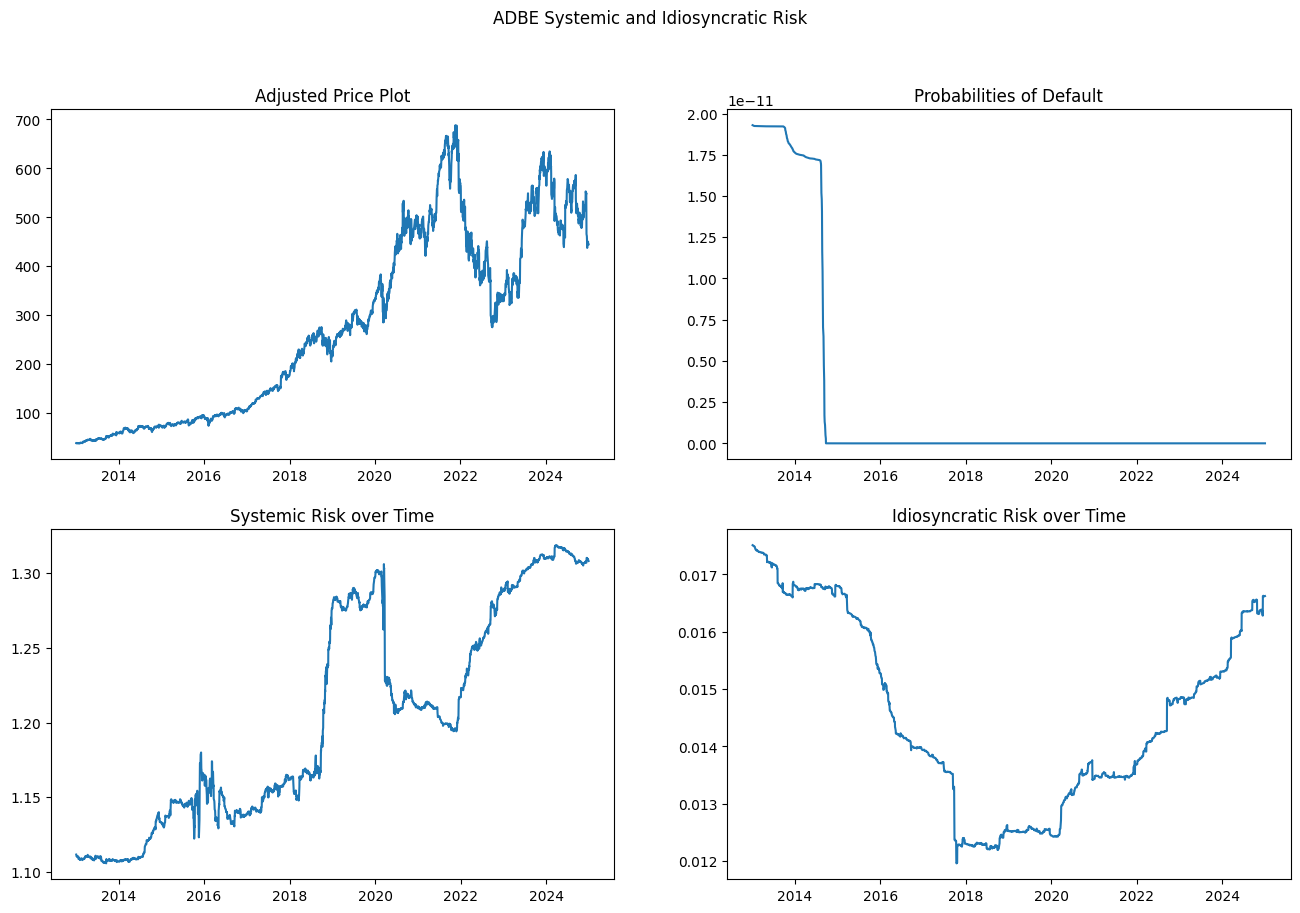

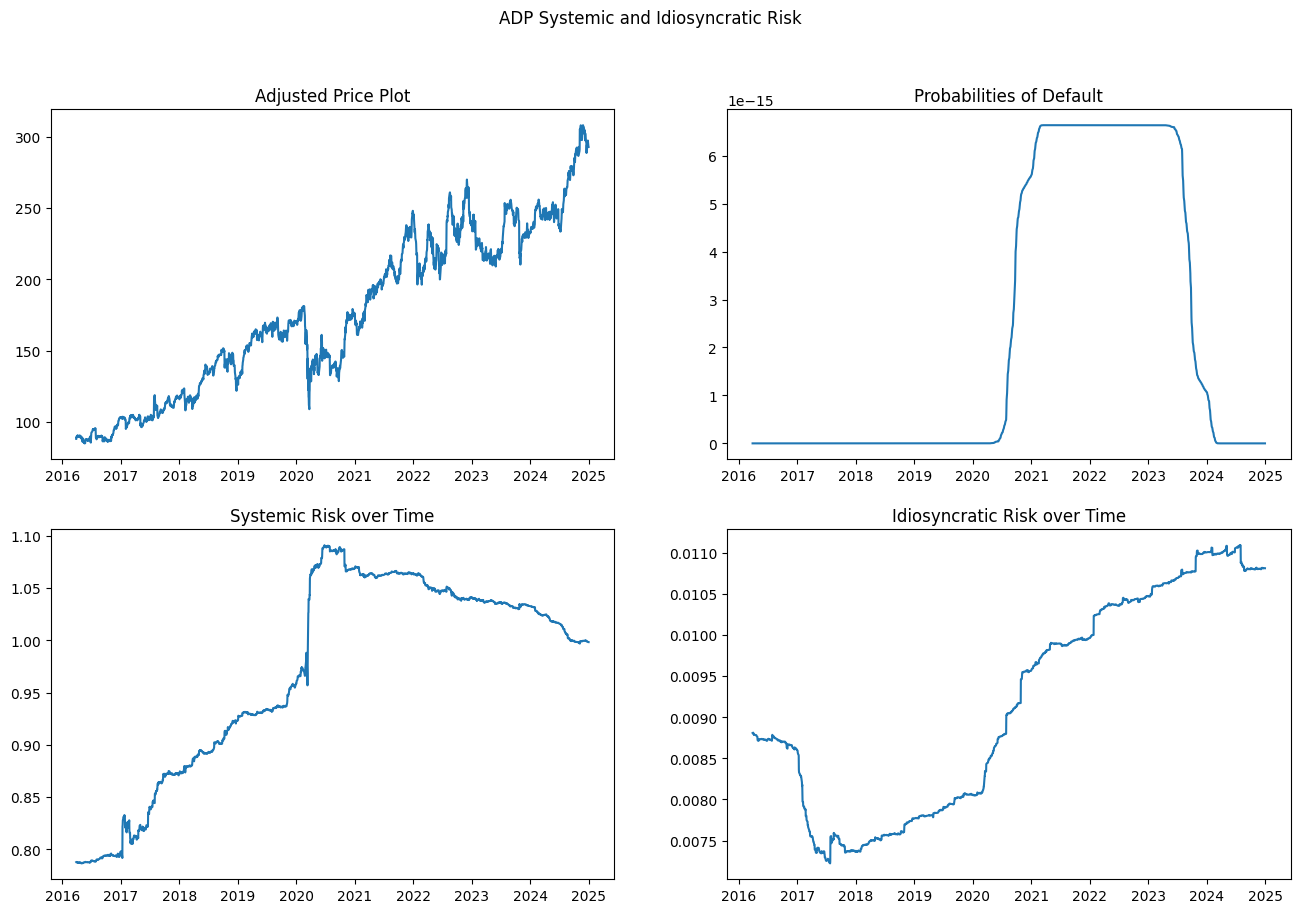

In [4]:
data = pd.read_csv(r'../data/clean_data.csv')
merton = pd.read_csv(r'../model/merton_model_output.csv')

spy_csv = pd.read_csv(r'../hypothesis-2/SPY.csv')
spy_csv['log_return'] = np.log(spy_csv['PRC'] / spy_csv['PRC'].shift(1))
spy_csv = spy_csv.set_index('date')
spy_csv.index = pd.to_datetime(spy_csv.index)

spy_logreturns = spy_csv['log_return'].dropna()


plot = True


for i in data['tic'].unique()[1:5]:

    stock = data[data['tic'] == str(i)]
    stock = stock.set_index('date')
    stock.index = pd.to_datetime(stock.index)


    probdef = merton[merton['tic'] == str(i)]
    probdef = probdef.set_index('date')
    probdef.index = pd.to_datetime(probdef.index)

    stock_logreturns = stock['log_return']


    spy_logreturns, stock_logreturns = spy_logreturns.align(stock_logreturns, join = 'inner', axis = 0)
    

    window_size = 252 * 7

    indices = spy_logreturns.index[window_size - 1:]
    stock_filter = stock.loc[indices]

    rolling_beta = []
    rolling_idio_vol = []
    rolling_dates = []

    for start in range(len(stock_logreturns) - window_size):
        end = start + window_size
        stock_window = stock_logreturns.iloc[start:end]
        market_window = spy_logreturns.iloc[start:end]
         
        X = sm.add_constant(market_window)
        y = stock_window
            
        model = sm.OLS(y, X)
        results = model.fit()
            
        _, beta = results.params
        residuals = results.resid
        idio_vol = np.std(residuals)
          
        rolling_beta.append(beta)
        rolling_idio_vol.append(idio_vol)
          
        rolling_dates.append(stock_window.index[-1])

    rolling_results = pd.DataFrame({
        'Date': rolling_dates,
        'Beta': rolling_beta,
        'Idiosyncratic Volatility': rolling_idio_vol
    })
    rolling_results.set_index('Date', inplace=True)

    rolling_pd = probdef['merton_pd'].rolling(window=252*3, min_periods=252*2).mean()

    rolling_pd_filt, rolling_results_filt = rolling_pd.align(rolling_results, join = 'inner', axis = 0)

    if plot == True:
        fig, ax = plt.subplots(2,2, figsize = (16,10))

        ax[1,0].plot(rolling_results['Beta'])
        ax[1,0].set_title("Systemic Risk over Time")
        ax[1,1].plot(rolling_results['Idiosyncratic Volatility'])
        ax[1,1].set_title("Idiosyncratic Risk over Time")
        ax[0,0].plot(stock_filter['PRC'])
        ax[0,0].set_title('Adjusted Price Plot')
        ax[0,1].plot(rolling_pd_filt)
        ax[0,1].set_title('Probabilities of Default')
        fig.suptitle(f'{i} Systemic and Idiosyncratic Risk')
        plt.show()


    #########################################################################################

    """


    X2 = sm.add_constant(rolling_results_filt)
    model2 = sm.OLS(rolling_pd_filt, X2)
    results2 = model2.fit()

    print(results2.summary())

    _, b, iv = results2.params
    print(f"{i} Beta: {b}")
    print(f"{i} IV: {iv}")"""